In [ ]:
#!pip install xgboost
#!pip install imblearn
!pip install catboost

In [28]:
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import itertools

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

In [1]:
import concurrent.futures

# from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score,train_test_split, StratifiedKFold, GroupKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.metrics.pairwise import _euclidean_distances

from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier

from imblearn.combine import SMOTEENN 
from imblearn.under_sampling import EditedNearestNeighbours 
from imblearn.over_sampling import SMOTE 

from collections import Counter

## Base de Dados

In [3]:
df = pd.read_csv('../../dados/df_train_class.csv', sep=';')

In [4]:
print('A base de dados apresenta {} registros e {} características.'.format(df.shape[0], df.shape[1]))

A base de dados apresenta 672657 registros e 48 características.


## Base de dados SMOTE

In [2]:
#path = "/content/drive/MyDrive/Dissertação/dados/procucao_gado_MS.csv"
path = '../../dados/dados_train_sm.csv'
df_smote = pd.read_csv(path, sep=';')

In [6]:
print('A base de dados apresenta {} registros e {} características.'.format(df_smote.shape[0], df_smote.shape[1]))

A base de dados apresenta 1393962 registros e 48 características.


## Histograma da Classe alvo com SMOTE

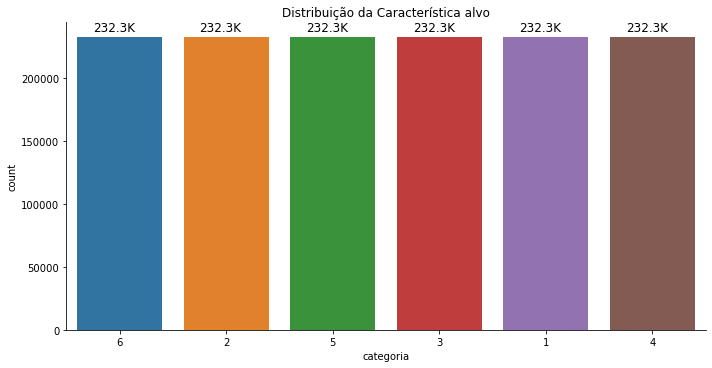

In [8]:
categorias = df_smote.categoria.value_counts()
plot_categoria = sns.catplot(x = "categoria", data = df_smote, 
                             kind="count",
                             aspect=2,
                             order = categorias.index).set(title='Distribuição da Característica alvo')
ax = plot_categoria.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.15,
            p.get_height() * 1.02,
            '{0:.1f}K'.format(p.get_height()/1000),
            color='black',
            rotation='horizontal',
            size='large')

## Variáveis

In [3]:
y = df_smote['categoria']
# Retirar a variável alvo e as variáveis obtidas após o abate 
X = df_smote.drop(['categoria'],axis=1)

In [4]:
# Valor para garantir que o método tenha comportamento aleatório, porém igual em todas as vezes que executado
SEED = 42

In [5]:
# Fornece índices de treinamento/teste para a divisão do conjunto de dados.  
skfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

## PCA

In [14]:
pca = PCA(n_components=30)
pca.fit(X)
X_pca = pca.transform(X)

## Funções

### Curva de aprendizado
Plot da curva de aprendizado visando identificar *score in* (conjunto de treinamento), *score out* (conjunto de teste), variância, e generalização do modelo.

In [10]:
# A função plot_learning_curve desenha um gráfico com os dados da matriz.
def plot_learning_curve(estimator, X, y, cv=None):
    
    # O gráfico é inicializado com as características principais
    plt.figure()
    plt.title("Curva de Aprendizado")
    plt.xlabel('Pontos do treinamento')
    plt.ylabel('Desempenho')
    plt.grid()
    
    # Calculamos os valores da curva de aprendizado, acrescentando os dados de 10 em 10 %
    sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    points, score_in, score_out = learning_curve(estimator, X, y, train_sizes=sizes, cv=cv)
    
    print('Score_in: ', score_in.mean())
    print('Score_out: ', score_out.mean())
    
    # Tiramos a média e o desvio padrão de cada sequência de testes. 
    # Por padrão é feita validação cruzada em 3 conjuntos de dados.
    mean_in = np.mean(score_in, axis=1)
    std_in = np.std(score_in, axis=1)
    mean_out = np.mean(score_out, axis=1)
    std_out = np.std(score_out, axis=1)
    
    # O desempenho de treinamento fica em vermelho e o de validação em verde
    plt.plot(points, mean_in, 'o-', color='red', label='Treinamento')
    plt.plot(points, mean_out, 'o-', color='green', label='Teste')
    
    # Os desvios ficam ao redor das linhas para indicar a variação no aprendizado
    plt.fill_between(points, mean_in - std_in,
                     mean_in + std_in, color='red', alpha=0.1)
    plt.fill_between(points, mean_out - std_out,
                     mean_out + std_out, color='green', alpha=0.1)
    
    plt.legend()
    return plt

### Matriz de Confusão

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Predição

In [6]:
# Para remover UserWarning do XGBClassifier: Use o parêmetro use_label_encoder=False 
# e codifique as classes no inervalo[0 ... n]
y=y.replace(6, 0)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [ ]:
# Valor sem o smote
# 0.46662801390649855

## Catboost - SMOTE

In [8]:
class_weight = class_weight.compute_class_weight(class_weight = "balanced",
                                                 classes = np.unique(y),
                                                 y = y)

In [9]:
#melhores hiperparametros obtidos do processo de otimização
cbc_params = {'iterations': 3000, 
              'l2_leaf_reg': 0.2982072500524196, 
              'depth': 12, 
              'loss_function':'MultiClass', 
              'learning_rate': 0.802149821813751
             }

### Cross Validate

In [10]:
model_catboost = CatBoostClassifier(**cbc_params, class_weights= class_weight, verbose=False)

In [11]:
score = cross_val_score(model_catboost, X, y, cv = skfolds)

print('Acurácia média da validação cruzada : %0.3f"' % score.mean())

Acurácia média da validação cruzada : 0.420"


### Modelo

In [12]:
cbc = CatBoostClassifier(**cbc_params, class_weights= class_weight, verbose=False)

In [13]:
cbc.fit(X_train, y_train)

In [14]:
y_pred_cbc = cbc.predict(X_test)

In [15]:
cbc_score = accuracy_score(y_test, y_pred_cbc)

In [16]:
print("Accuracy score CatBoost: ", cbc_score)

Accuracy score CatBoost:  0.41594590005954246


In [19]:
df_smote=pd.DataFrame({'Actual': y_test, 'Predicted':y_pred_cbc.ravel()})

/home/ygobrito/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

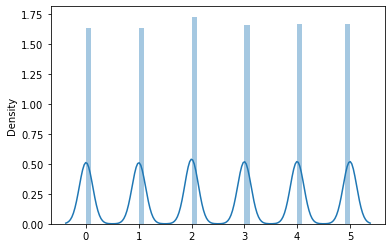

In [20]:
sns.distplot(y_pred_cbc)

### Matriz de Confusão

In [26]:
matrix_cbc = confusion_matrix(y_pred=y_pred_cbc, y_true=y_test)

Confusion matrix, without normalization
[[24837  6250 10074  8495 13294  6698]
 [ 5787 36071 15937  3506  6775  1400]
 [ 9654 14195 20442  8562 13242  3640]
 [ 8418  3406  8978 31243  3959 13910]
 [12796  7291 13421  4325 24460  7138]
 [ 7070  1180  3485 13390  7969 36891]]


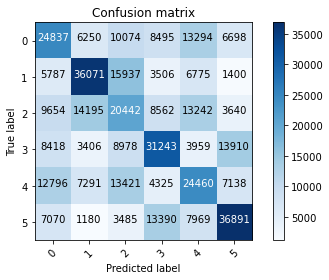

In [29]:
plot_confusion_matrix(matrix_cbc, ['0','1', '2', '3', '4', '5'])

### Relatório

In [ ]:
print("CatBoost")
print(classification_report(y_pred=y_pred_cbc, y_true=y_test))

## ...

In [12]:
#melhores hiperparametros obtidos do processo de otimização
xgb_params = {'colsample_bytree': 0.32082495952188383, 'eta': 0.02, 'gamma': 1.8030627974482705e-05, 
              'lambda': 1.0479107603833961e-07, 'max_depth': 17, 'min_child_weight': 17, 
              'reg_alpha': 8.178450742773128e-07, 'subsample': 1.0
             }
rfc_params={'bootstrap': 'True',
 'criterion': 'entropy',
 'max_depth': 19,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 39,
 'n_estimators': 366}

In [13]:
knn_baseline = KNeighborsClassifier(n_neighbors=3)
knn_baseline.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [14]:
xgb_baseline = XGBClassifier(objective="multi:softmax", num_class= 6, eval_metric='mlogloss',
                             random_state=SEED, nthread=-1,  use_label_encoder=False, **xgb_params)
xgb_baseline.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.32082495952188383, early_stopping_rounds=None,
              enable_categorical=False, eta=0.02, eval_metric='mlogloss',
              gamma=1.8030627974482705e-05, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              lambda=1.0479107603833961e-07, learning_rate=0.0199999996,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=17,
              max_leaves=0, min_child_weight=17, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              nthread=-1, num_class=6, num_parallel_tree=1, ...)

In [15]:
rfc_baseline = RandomForestClassifier(n_jobs=-1, random_state=SEED, **rfc_params)
rfc_baseline.fit(X_train, y_train)

RandomForestClassifier(bootstrap='False', max_depth=20, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=32,
                       n_estimators=247, n_jobs=-1, random_state=42)

In [17]:
y_pred_knn = knn_baseline.predict(X_test)
y_pred_xgb = xgb_baseline.predict(X_test)
y_pred_rfc = rfc_baseline.predict(X_test)

In [18]:
knn_score = accuracy_score(y_test, y_pred_knn)
xgb_score = accuracy_score(y_test, y_pred_xgb)
rfc_score = accuracy_score(y_test, y_pred_rfc)

print("Accuracy score (KNN): ", knn_score)
print("Accuracy score (XGB): ", xgb_score)
print("Accuracy score (RFC): ", rfc_score)

Accuracy score (KNN):  0.42648093638192647
Accuracy score (XGB):  0.512958503057513
Accuracy score (RFC):  0.512913904003013


### Matriz de confusão KNN

In [19]:
matrix_knn = confusion_matrix(y_pred=y_pred_knn, y_true=y_test)

Confusion matrix, without normalization
[[15774  2481  7116  2022  3802  1098]
 [ 4495 24408 11784   361  1463    25]
 [12415 15921 31503  2648  6810   536]
 [ 3919  1130  4958  3895   554   741]
 [ 8396  3792 10895   893  8921  1008]
 [ 2304   275  1633  1188  1072  1562]]


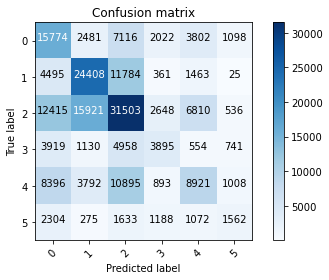

In [20]:
plot_confusion_matrix(matrix_knn, ['0','1', '2', '3', '4', '5'])

### Matriz de confusão XGB

In [21]:
matrix_xgb = confusion_matrix(y_pred=y_pred_xgb, y_true=y_test)

Confusion matrix, without normalization
[[13201  1464 10645  2054  3769  1160]
 [  928 24032 16704   195   653    24]
 [ 4238  9268 48437  2085  5331   474]
 [ 2114   504  6627  4566   504   882]
 [ 4192  1028 16038   596 10951  1100]
 [ 1376    76  1705  1122  1428  2327]]


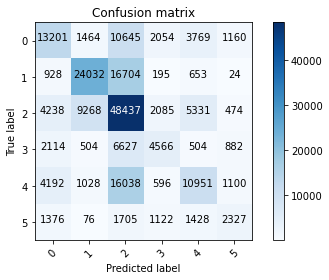

In [22]:
plot_confusion_matrix(matrix_xgb, ['0','1', '2', '3', '4', '5'])

### Matriz de confusão RFC

In [23]:
matrix_rfc = confusion_matrix(y_pred=y_pred_rfc, y_true=y_test)

Confusion matrix, without normalization
[[13514  1443 10249  2028  3898  1161]
 [  978 23864 16800   205   667    22]
 [ 4460  9171 48087  2152  5472   491]
 [ 2224   521  6442  4551   553   906]
 [ 4269   999 15724   650 11140  1123]
 [ 1413    77  1549  1154  1492  2349]]


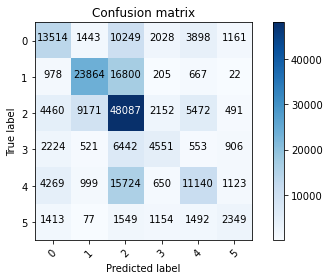

In [24]:
plot_confusion_matrix(matrix_rfc, ['0','1', '2', '3', '4', '5'])

In [29]:
print("KNN")
print(classification_report(y_pred=y_pred_knn, y_true=y_test))
print('\n')
print("XGB")
print(classification_report(y_pred=y_pred_xgb, y_true=y_test))
print('\n')
print("RFC")
print(classification_report(y_pred=y_pred_rfc, y_true=y_test))

KNN
              precision    recall  f1-score   support

           0       0.33      0.49      0.40     32293
           1       0.51      0.57      0.54     42536
           2       0.46      0.45      0.46     69833
           3       0.35      0.26      0.30     15197
           4       0.39      0.26      0.32     33905
           5       0.31      0.19      0.24      8034

    accuracy                           0.43    201798
   macro avg       0.39      0.37      0.37    201798
weighted avg       0.43      0.43      0.42    201798



XGB
              precision    recall  f1-score   support

           0       0.51      0.41      0.45     32293
           1       0.66      0.56      0.61     42536
           2       0.48      0.69      0.57     69833
           3       0.43      0.30      0.35     15197
           4       0.48      0.32      0.39     33905
           5       0.39      0.29      0.33      8034

    accuracy                           0.51    201798
   macro avg 

### A Curva ROC e AUROC

In [ ]:
plot_roc_curve(knn_baseline, X_test, y_test)

C:\Users\1374914\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn.metrics import RocCurveDisplay

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred_knn)cd 
plt.show()

In [ ]:
RocCurveDisplay.from_estimator(knn_baseline, X_test, y_test)
plt.show()

## ENN - Edited Nearest Neighbour
Subamostragem com base no método do vizinho mais próximo. 

In [10]:
enn = EditedNearestNeighbours(n_jobs=-1)
X_enn, y_enn = enn.fit_resample(X_scaled, y)

In [ ]:
print('Dados originais: {}'.format(Counter(y)))
print('Dados reamostrados: {}'.format(Counter(y_enn)))

In [ ]:
# Conjunto de dados reamostrados para arquivo csv
df_X_enn = pd.DataFrame(X_enn)
df_train_enn = df_X_enn.join(y_enn)
df_train_enn.to_csv("dados_train_enn.csv", sep=';', index=False)

## SMOTE - Synthetic Minority Over-sampling Technique
Sobreamostragem 

In [ ]:
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_scaled, y)

In [ ]:
print('Dados originais: {}'.format(Counter(y)))
print('Dados reamostrados: {}'.format(Counter(y_sm)))

In [ ]:
# Conjunto de dados reamostrados para arquivo csv
df_X_sm = pd.DataFrame(X_sm)
df_train_sm = df_X_sm.join(y_sm)
df_train_sm.to_csv("dados_train_sm.csv", sep=';', index=False)

## SMOTEENN - SMOTE e Edited Nearest Neighbours 

Sobreamostragem combinando SMOTE e limpeza com ENN.

In [ ]:
smote_enn = SMOTEENN(random_state=SEED, n_jobs=-1)
X_smoteenn, y_smoteenn = smote_enn.fit_resample(X_scaled, y)

In [ ]:
print('Dados originais: {}'.format(Counter(y)))
print('Dados reamostrados: {}'.format(Counter(y_smoteenn)))

In [ ]:
# Conjunto de dados reamostrados para arquivo csv
df_X_smoteenn = pd.DataFrame(X_smoteenn)
df_train_smoteenn = df_X_smoteenn.join(y_smoteenn)
df_train_smoteenn.to_csv("dados_train_smoteenn.csv", sep=';', index=False)

# Gráficos

In [31]:
def categoria_catplot(y, metodo):
    df_y = pd.DataFrame(y)
    plot = sns.catplot(x = "categoria", data = df_y, 
            kind="count", 
            aspect=2).set(title='Distribuição da Característica alvo após ' + metodo)

    ax = plot.facet_axis(0,0)
    for p in ax.patches:
        ax.text(p.get_x() + 0.15, 
                p.get_height() * 1.02, 
               '{0:.1f}K'.format(p.get_height()/1000),   #Used to format it K representation
                color='black', 
                rotation='horizontal', 
                size='large')

In [4]:
nomes_colunas = ['tipificacao_1', 'tipificacao_2', 'tipificacao_3',
       'classificacao_estabelecimento', 'outros_incentivos',
       'pratica_recuperacao_pastagem', 'fertiirrigacao', 'ilp', 'ilpf', 'ifp',
       'fabrica_racao', 'identificacao_individual', 'regua_de_manejo', 'bpa',
       'participa_aliancas_mercadologicas', 'rastreamento_sisbov',
       'tot1m_chuva', 'med1m_formituinst', 'med1m_ndvi', 'med1m_prer_soja',
       'med1m_prer_milho', 'med1m_prer_boi', 'tot3m_chuva',
       'med3m_formituinst', 'med3m_ndvi', 'med3m_prer_soja',
       'med3m_prer_milho', 'med3m_prer_boi', 'tot6m_chuva',
       'med6m_formituinst', 'med6m_ndvi', 'med6m_prer_soja',
       'med6m_prer_milho', 'med6m_prer_boi', 'tot12m_chuva',
       'med12m_formituinst', 'med12m_ndvi', 'med12m_prer_soja',
       'med12m_prer_milho', 'med12m_prer_boi', 'cnt1m_cl_ituinst',
       'cnt3m_cl_ituinst', 'cnt6m_cl_ituinst', 'cnt12m_cl_ituinst',
       'longitude', 'latitude', 'mes', 'categoria']

In [3]:
df_enn = pd.read_csv('../../dados/dados_train_enn.csv', sep=';')

In [5]:
df_enn.columns = nomes_colunas

In [33]:
df_sm = pd.read_csv('dados/dados_train_sm.csv', sep=';')

In [34]:
df_smoteenn = pd.read_csv('dados/dados_train_smoteenn.csv', sep=';')

In [ ]:
def plot_categoria(df,metodo):
    categorias = df.categoria.value_counts()
    plot_categoria = sns.catplot(x = "categoria", data = df,
                                 kind="count",
                                 aspect=2).set(title='Distribuição da Característica alvo ' + metodo)    
    ax = plot_categoria.facet_axis(0,0)
    for p in ax.patches:
        ax.text(p.get_x() + 0.15,
                p.get_height() * 1.02,
                '{0:.1f}K'.format(p.get_height()/1000),
                color='black',
                rotation='horizontal',
                size='large')

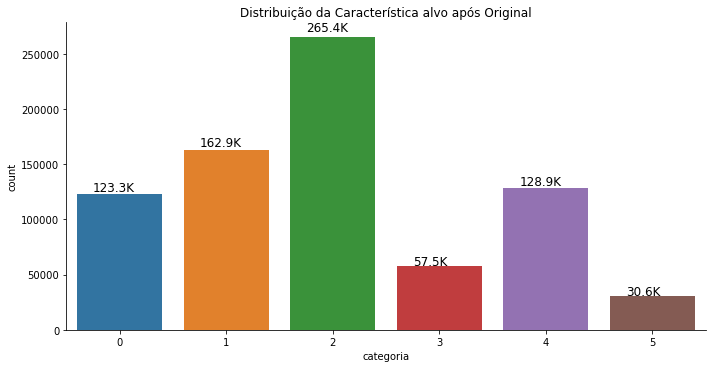

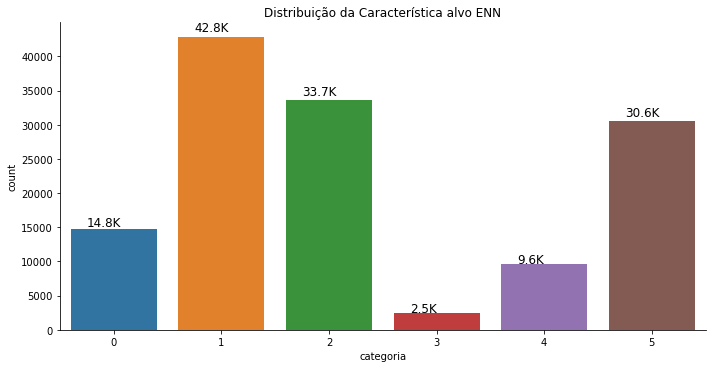

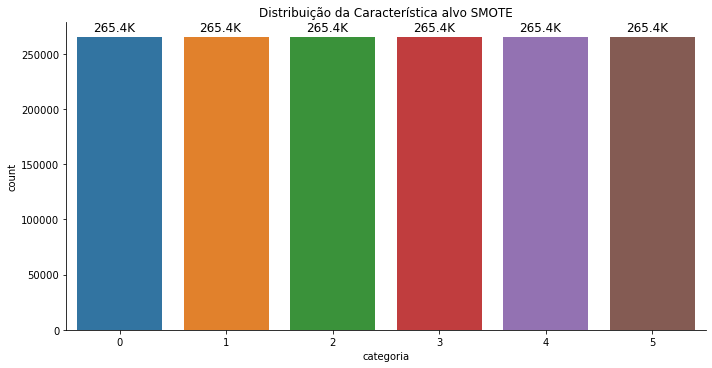

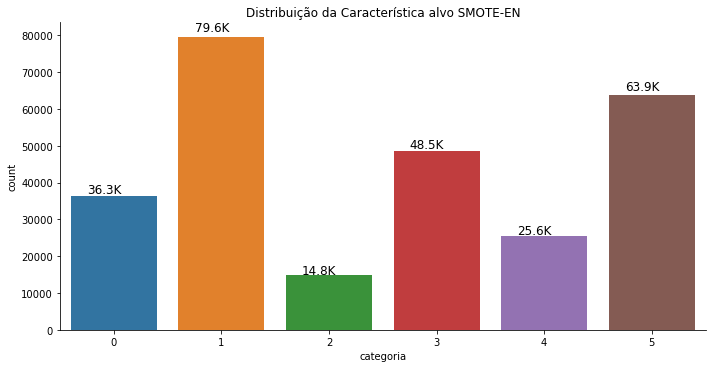

In [35]:
categoria_catplot(y, 'Original')
plot_categoria(df_enn, 'ENN')
plot_categoria(df_sm, 'SMOTE')
plot_categoria(df_smoteenn, 'SMOTE-EN')

# Treinamento com dados balanceados

### XGBClassifier + ENN

In [31]:
y_enn = df_enn['categoria']
# Retirar a variável alvo e as variáveis obtidas após o abate 
X_enn = df_enn.drop(['categoria'],axis=1)

In [ ]:
xgb_enn = XGBClassifier(objective="multi:softmax", num_class= 6, eval_metric='mlogloss', 
                        random_state=SEED, nthread=-1, use_label_encoder=False, **xgb_params)

plot_learning_curve(xgb_enn, X_enn, y_enn, cv=kfolds)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_enn, y_enn, test_size=.2)

In [ ]:
# Matriz de confusão
xgb_enn.fit(X_train, y_train)
pred = xgb_enn.predict(X_test)
matrix = confusion_matrix(y_pred=pred, y_true=y_test)
plot_confusion_matrix(matrix, ['0','1', '2', '3', '4', '5'])

In [ ]:
print(classification_report(y_pred=pred, y_true=y_test))

### XGBClassifier + SMOTE

In [ ]:
xgb_sm = XGBClassifier(objective="multi:softmax", num_class= 6, eval_metric='mlogloss', 
                        random_state=SEED, nthread=-1, use_label_encoder=False, **xgb_params)

plot_learning_curve(xgb_enn, X_enn, y_enn, cv=kfolds)

### XGBClassifier + SMOTEENN

In [ ]:
xgb = XGBClassifier(objective="multi:softmax", num_class= 6, eval_metric='mlogloss', 
                    random_state=SEED, nthread=-1, use_label_encoder=False, **xgb_params)
t0 = time.time()
score = cross_val_score(xgb, X_resampled, y_resampled_xgb, cv = kfolds,  n_jobs=-1, pre_dispatch=2, error_score='raise')
print('A pontuação média da validação cruzada : %0.3f"' % score.mean())
print("Pronto em:  %0.3f" %(time.time()-t0))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_xgb, test_size=.2, random_state=SEED)

xgb = XGBClassifier(objective="multi:softmax", num_class= 6, eval_metric='mlogloss', random_state=SEED, nthread=-1, use_label_encoder=False)
plot_learning_curve(xgb, X_train, y_train, cv=10)

In [ ]:
# Matriz de confusão
xgb = XGBClassifier(objective="multi:softmax", num_class= 6, eval_metric='mlogloss', random_state=SEED, nthread=-1, use_label_encoder=False)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
matrix = confusion_matrix(y_pred=pred, y_true=y_test)
plot_confusion_matrix(matrix, ['1', '2', '3', '4', '5', '0'])

In [ ]:
print(classification_report(y_pred=pred, y_true=y_test))

## RFC + ENN

In [6]:
y_enn = df_enn['categoria']
# Retirar a variável alvo e as variáveis obtidas após o abate 
X_enn = df_enn.drop(['categoria'],axis=1)

In [10]:
rfr_enn = RandomForestClassifier(n_jobs=-1, random_state=SEED, **rfc_params)

Score_in:  0.9931895568120251
Score_out:  0.6305797381509763


<module 'matplotlib.pyplot' from '/home/ygobrito/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

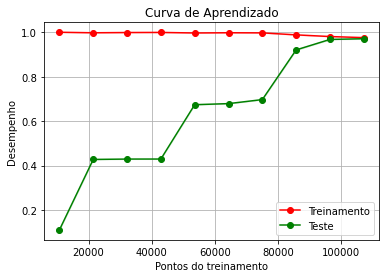

In [16]:
plot_learning_curve(rfr_enn, X_enn, y_enn, cv=skfolds)

Confusion matrix, without normalization
[[2813    6   14    0    6  136]
 [   0 8454    0    0    0   16]
 [   0    7 6741    0    5   52]
 [   0    1    0  430    0   47]
 [   4    1    3    0 1911   80]
 [ 126   41  138   52   76 5649]]


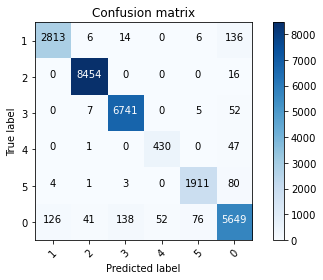

In [14]:
# Matriz de confusão
X_train, X_test, y_train, y_test = train_test_split(X_enn, y_enn, test_size=.2)

rfr_enn.fit(X_train, y_train)
pred = rfr_enn.predict(X_test)
matrix = confusion_matrix(y_pred=pred, y_true=y_test)
plot_confusion_matrix(matrix, ['1', '2', '3', '4', '5', '0'])

In [17]:
print(classification_report(y_pred=pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2975
           1       0.99      1.00      1.00      8470
           2       0.98      0.99      0.98      6805
           3       0.89      0.90      0.90       478
           4       0.96      0.96      0.96      1999
           5       0.94      0.93      0.94      6082

    accuracy                           0.97     26809
   macro avg       0.95      0.95      0.95     26809
weighted avg       0.97      0.97      0.97     26809



In [34]:
path = 'dados/procucao_gado_MS_test.csv'
df_teste = pd.read_csv(path, sep=';')

In [35]:
y = df_teste['categoria']
# Retirar a variável alvo e as variáveis obtidas após o abate 
X = df_teste.drop(['categoria'],axis=1)

In [36]:
y=y.replace(6, 0)

In [37]:
pred = rfr_enn.predict(X)

Confusion matrix, without normalization
[[    0  6762 15876     0   165  7858]
 [    0 21212 14320     0   210  4723]
 [    2 21727 30841     0   365 13916]
 [    1  2969  2817     0     0  8373]
 [    0  6919 17301     0   202  8061]
 [    3   474   689     0     0  6402]]


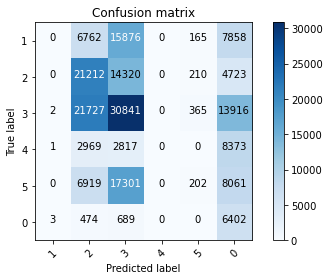

In [39]:
matrix = confusion_matrix(y_pred=pred, y_true=y)
plot_confusion_matrix(matrix, ['0','1', '2', '3', '4', '5'])

Confusion matrix, without normalization
[[    0  6762 15876     0   165  7858]
 [    0 21212 14320     0   210  4723]
 [    2 21727 30841     0   365 13916]
 [    1  2969  2817     0     0  8373]
 [    0  6919 17301     0   202  8061]
 [    3   474   689     0     0  6402]]


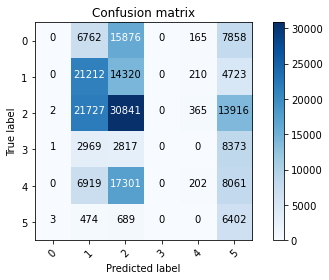

In [40]:
matrix = confusion_matrix(y_pred=pred, y_true=y)
plot_confusion_matrix(matrix, ['0','1', '2', '3', '4', '5'])

print(classification_report(y_pred=pred, y_true=y))

### RFC + SMOTE

In [16]:
y_sm = df_sm['categoria']
# Retirar a variável alvo e as variáveis obtidas após o abate 
X_sm = df_sm.drop(['categoria'],axis=1)

In [17]:
rfr_sm = RandomForestClassifier(n_jobs=-1, random_state=SEED, **rfc_params)

KeyboardInterrupt: 

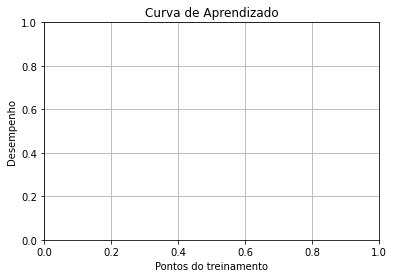

In [19]:
plot_learning_curve(rfr_sm, X_sm, y_sm, cv=skfolds)

In [ ]:
# Matriz de confusão
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=.2)

rfr_sm.fit(X_train, y_train)
pred = rfc.predict(X_test)
matrix = confusion_matrix(y_pred=pred, y_true=y_test)
plot_confusion_matrix(matrix, ['1', '2', '3', '4', '5', '0'])